In [28]:
import math
import numpy as np
import scipy.stats as si

#### Introduction
What I am doing and why

#### Black-Scholes Implementation

In [12]:
def black_scholes(S, K, T, r, vol):
    # S = underlying price
    # K = strike price
    # T = time to expiration
    # r = risk-free rate
    # vol = volatility (sigma)

    d1 = (np.log(S / K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)

    call_price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    return round(float(call_price), 2)

In [13]:
black_scholes(100, 100, 1, 0.05, 0.2)

10.45

#### Monte Carlo Implementation
The formula used is the Geometric Brownian Motion equation. This is because it uses the same assumptions as the BS formula, so should give roughly the same result (slightly differs due to random number being used in MC simulation)

In [24]:
def monte_carlo(S, K, T, r, vol, n = 10000):
    Z = np.random.standard_normal(n)

    ST = S * np.exp((r - 0.5 * vol**2) * T + vol * np.sqrt(T) * Z)

    payoff = np.maximum(ST - K, 0)

    call_price = np.exp(-r * T) * np.mean(payoff)
    return round(float(call_price), 2)

In [27]:
monte_carlo(100, 100, 1, 0.05, 0.2)

10.43

#### Comparison

In [55]:
S = 100
K = 100
T = 1
r = 0.05
vol = 0.2
bs = black_scholes(S, K, T, r, vol)
mc = monte_carlo(S, K, T, r, vol, n = 10000)

print("Black-Scholes: ", bs)
print("Monte Carlo: ", mc)
print("Difference: ", round(abs(bs-mc), 2))

Black-Scholes:  10.45
Monte Carlo:  10.41
Difference:  0.04


#### Monte Carlo Convergence vs Number of Simulations

In [67]:
import numpy as np

n_values = [100, 500, 1000, 5000, 10000, 50000]
results = []

bs_price = black_scholes(S, K, T, r, vol)

for n in n_values:
    mc_price = monte_carlo(S, K, T, r, vol, n=n)
    error = abs(mc_price - bs_price)
    results.append((n , mc_price, error))

for i in results:
    print(f"n = {i[0]}  |  MC price = {i[1]}  |  Error = {round(i[2], 2)}")

n = 100  |  MC price = 7.47  |  Error = 2.98
n = 500  |  MC price = 11.89  |  Error = 1.44
n = 1000  |  MC price = 10.82  |  Error = 0.37
n = 5000  |  MC price = 10.57  |  Error = 0.12
n = 10000  |  MC price = 10.57  |  Error = 0.12
n = 50000  |  MC price = 10.41  |  Error = 0.04


MC converges to the BS price, demonstrated by decreasing error. Since it is random, the errors fluctuate a lot and do not give a consistent value for what the error is. I want to find what the average error is over multiple runs.

##### Averaging over multiple runs

In [66]:
n_values = [100, 500, 1000, 5000, 10000, 50000]
results = []
n_runs = 30

bs_price = black_scholes(S, K, T, r, vol)

for n in n_values:
    mc_prices = []

    for i in range(n_runs):
        mc_price = monte_carlo(S, K, T, r, vol, n=n)
        mc_prices.append(mc_price)

    avg_mc = np.mean(mc_prices)
    avg_error = abs(avg_mc - bs_price)
    results.append((n, avg_mc, avg_error))

for i in results:
    print(f"n = {i[0]}  |  avg MC price = {i[1]}  |  avg Error = {round(i[2], 2)}")

n = 100  |  avg MC price = 10.254333333333333  |  avg Error = 0.2
n = 500  |  avg MC price = 10.420333333333332  |  avg Error = 0.03
n = 1000  |  avg MC price = 10.389000000000001  |  avg Error = 0.06
n = 5000  |  avg MC price = 10.456666666666667  |  avg Error = 0.01
n = 10000  |  avg MC price = 10.469000000000001  |  avg Error = 0.02
n = 50000  |  avg MC price = 10.431  |  avg Error = 0.02


Since it is random (about BS price), averaging over multiple runs leads to a decreasing error as MC is converging, so this again proves that MC converges to the BS price. However, I want to find the average error of each individual mc price, rather than the average error of the average mc price.

In [69]:
n_values = [100, 500, 1000, 5000, 10000, 50000]
results = []
n_runs = 30

bs_price = black_scholes(S, K, T, r, vol)

for n in n_values:
    errors = []

    for i in range(n_runs):
        mc_price = monte_carlo(S, K, T, r, vol, n=n)
        error = abs(mc_price - bs_price)
        errors.append(error)

    avg_error = np.mean(errors)
    results.append((n, avg_error))

for i in results:
    print(f"n = {i[0]}  |  avg Error = {round(i[1], 2)}")

n = 100  |  avg Error = 1.2
n = 500  |  avg Error = 0.55
n = 1000  |  avg Error = 0.4
n = 5000  |  avg Error = 0.14
n = 10000  |  avg Error = 0.08
n = 50000  |  avg Error = 0.04


Gives a more consistent error when run multiple times, showing the impact of running a different number of MC simulations.

#### Delta and Gamma
##### Delta
Delta approx. = how much the option price changes if the underlying price moves by £1, for a small change. It is given by:
∆ = N(d1), where d1 is used in the Black-Scholes formula

In [77]:
def black_scholes_delta(S, K, T, r, vol):
    d1 = (np.log(S / K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    return round(float(si.norm.cdf(d1)),2)

In [78]:
black_scholes_delta(100, 100, 1, 0.05, 0.2)

0.64

A Delta of 0.64 implies that if the underlying stock price increases by £1, then the option value will increase by approximately £0.64. Delta is crucial for hedging, as a trader can offset the risk of an option by taking the opposite position in the underlying stock in proportion to the Delta. For example, if you sell one call option, and Delta = 0.6, to hedge, you buy 0.6 shares of the underlying stock. 

##### Plot Delta vs Stock Price 

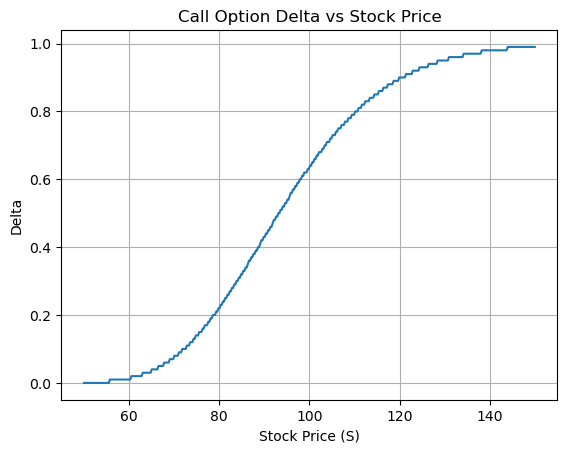

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def bs_delta(S, K, T, r, vol):
    d1 = (np.log(S / K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    return round(float(norm.cdf(d1)),2)

K = 100
T = 1
r = 0.05
vol = 0.2

S_values = np.linspace(50, 150, 400)
deltas = [bs_delta(S, K, T, r, vol) for S in S_values]

plt.plot(S_values, deltas)
plt.xlabel("Stock Price (S)")
plt.ylabel("Delta")
plt.title("Call Option Delta vs Stock Price")
plt.grid(True)
plt.show()

##### Gamma
Gamma measures how fast Delta changes, telling you how much Delta will change if the stock moves. At-the-money-options have very high Gamma, meaning Delta moves a lot even for small stock price changes, so you must hedge frequently. Delta is good for hedging against small movements. However, if the underlying stock price moves a lot, the Delta changes and this is where Gamma comes into play, allowing investors to adjust their holdings according to the new Delta. 

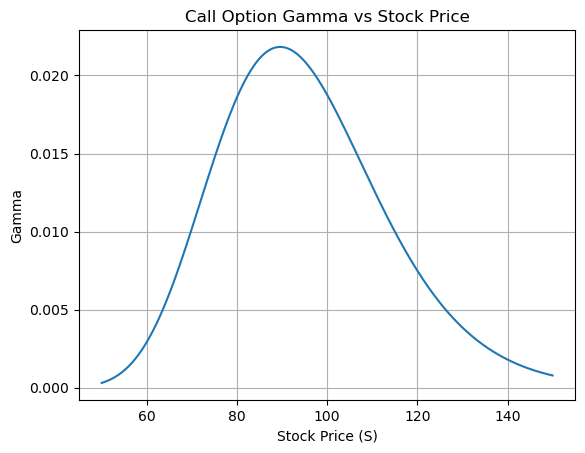

In [81]:
def bs_gamma(S, K, T, r, vol):
    d1 = (np.log(S / K) + (r + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    return norm.pdf(d1) / (S * vol * np.sqrt(T))

gammas = [bs_gamma(S, K, T, r, vol) for S in S_values]

plt.plot(S_values, gammas)
plt.xlabel("Stock Price (S)")
plt.ylabel("Gamma")
plt.title("Call Option Gamma vs Stock Price")
plt.grid(True)
plt.show()